In [ ]:
from tokenizers import Tokenizer
from tokenizers.trainers import WordLevelTrainer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast, AutoTokenizer
from transformers import BertForMaskedLM, BertConfig, PreTrainedModel, AutoModel, AutoModelForSequenceClassification
from transformers import DataCollatorForLanguageModeling, DataCollatorWithPadding
from transformers import Trainer, TrainingArguments
import torch
from nltk.parse.corenlp import CoreNLPParser
from nltk.tag.hunpos import HunposTagger
from nltk.tokenize import word_tokenize
import stanza
import nltk
import numpy as np
from datasets import load_dataset, load_from_disk
from numerize import numerize
import wandb
import os 
import typing
import tokenizers
from tqdm.auto import trange, tqdm
from itertools import cycle
import evaluate
import datasets
from datasets import Dataset


In [ ]:
import transformers
transformers.__version__

'4.18.0'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
config = BertConfig.from_json_file('/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/', local_files_only=True)

Didn't find file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/added_tokens.json. We won't load it.
loading file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/tokenizer.json
loading file None
loading file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/special_tokens_map.json
loading file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/tokenizer_config.json


In [ ]:
model = AutoModel.from_pretrained('/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/', local_files_only=True, num_labels=3)


loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_

# visualize POS embeddings

In [ ]:
id2token = {v:k for k,v in tokenizer.vocab.items()}

In [ ]:
embs = model.embeddings.word_embeddings.weight.detach().numpy()

In [ ]:
pca = PCA(2)
pca.fit(embs)
transformed_embs = pca.transform(embs)

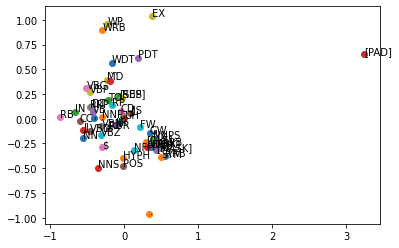

In [ ]:
for i in range(embs.shape[0]):
    plt.scatter(transformed_embs[i,0], transformed_embs[i,1])
    plt.annotate(f'{id2token[i]}', (transformed_embs[i,0], transformed_embs[i,1]))
# plt.legend()
plt.show()

# synthetic style

In [ ]:
def gene_sentences(num_sentences, sentence_length, tokens, dists, prob_of_dist=None):
    dist_idx = np.arange(0,len(dists), dtype=int).tolist()
    if prob_of_dist is None:
        prob_of_dist = np.ones(len(dists))/len(dists)
    sentences = []
    labels = []
    for i in range(num_sentences):
        i_dist = np.random.choice(dist_idx, p = prob_of_dist)
        sent = np.random.choice(common_tokens, size = 15, p = dists[i_dist]).tolist()
        sentences.append(' '.join(sent))
        labels.append(i_dist)
    return sentences, labels

In [ ]:
def get_style_dists(num_styles, diff, tokens = ['NN', 'VB', 'DT', 'IN', 'JJ', 'PRP', 'RB',]):
    num_tokens = len(tokens)
    other_prob = (1-diff)/num_tokens
    dominent_prob = other_prob + diff
    dists = []
    for i in range(num_styles):
        dist = other_prob*np.ones(num_tokens)
        dist[i] = dominent_prob
        dists.append(dist.tolist())
    return dists

In [ ]:
# num_styles = 2
# diff = 0.3
# common_tokens = ['NN', 'VB', 'DT', 'IN', 'JJ', 'PRP', 'RB',]
# dists = get_style_dists(num_styles, diff, tokens=common_tokens)

# sentence_length = 15
# train_sentences, train_labels = gene_sentences(2000, sentence_length, common_tokens, dists)
# test_sentences, test_labels = gene_sentences(200, sentence_length, common_tokens, dists)

In [ ]:
def freeze_model(model, freeze_bert):
    '''
    if freeze_bert == True, freeze all layer. 
    if freeze_bert is a positive integer, freeze the bottom {freeze_bert} attention layers
    negative integer should also work
    '''
    if freeze_bert==True:
        for param in model.bert.parameters():
            param.requires_grad = False
    elif isinstance(freeze_bert, (int, np.int32, np.int64, torch.int32, torch.int64)):
        for param in model.bert.embeddings.parameters():
            param.requires_grad = False  
        for layer in model.bert.encoder.layer[:freeze_bert]: 
            for param in layer.parameters():
                param.requires_grad = False  
    return model

In [ ]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_preds):
    logits, labels = eval_preds.logits, eval_preds.labels
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer, padding = True, return_tensors = 'pt')


In [ ]:
def nested_to(dic, device):
    for k,v in dic.items():
        dic[k] = v.to(device)
    return dic

In [ ]:
import datasets

# metric = datasets.load_metric('accuracy')

# for x in trainer.get_eval_dataloader(test_dataset):
#     labels = x['labels']
#     x = nested_to(x, device)
#     model_predictions = model(**x)
#     metric.add_batch(predictions=model_predictions.logits.argmax(axis=-1).cpu().detach().numpy(), references=labels)

# final_score = metric.compute()

In [ ]:
def tokenize(examples):
    labels = examples['labels']
    out = tokenizer(examples['text'], padding=True, truncation=True, max_length=128)
    out.update({'labels':labels})
    return out

In [ ]:
epochs = 20
batchsize = 128
num_styles = 2
sentence_length = 15
num_trainset = 2000
num_testset = 200

common_tokens = ['NN', 'VB', 'DT', 'IN', 'JJ', 'PRP', 'RB',]

DIFF = [0.1,0.2,0.3,0.4]
NUM_SENT = [10, 15, 25]
FREEZE_BERT = [0,1,2,3]

DIFF, NUM_SENT, FREEZE_BERT = np.meshgrid(DIFF, NUM_SENT, FREEZE_BERT)
DIFF, NUM_SENT, FREEZE_BERT = DIFF.flatten(), NUM_SENT.flatten(), FREEZE_BERT.flatten()

num_runs = len(DIFF)

for i_run in trange(num_runs):
    
    diff = DIFF[i_run]
    sentence_length = NUM_SENT[i_run]
    freeze_bert = FREEZE_BERT[i_run]
    
    # create synthetic POS sequences
    dists = get_style_dists(num_styles, diff, tokens=common_tokens)

    train_sentences, train_labels = gene_sentences(num_trainset, sentence_length, common_tokens, dists)
    test_sentences, test_labels = gene_sentences(num_testset, sentence_length, common_tokens, dists)

    train_dataset = Dataset.from_dict({"text": train_sentences, 'labels':train_labels})
    train_dataset = train_dataset.map(tokenize, batched=True)
    train_dataset = train_dataset.remove_columns(['text'])

    test_dataset = Dataset.from_dict({"text": test_sentences, 'labels':test_labels})
    test_dataset = test_dataset.map(tokenize, batched=True)
    test_dataset = test_dataset.remove_columns(['text'])
    
    # init models
    model = AutoModelForSequenceClassification.from_pretrained('/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/', local_files_only=True, num_labels=num_styles)
    model = freeze_model(model, freeze_bert)
    
    # trainer config
    training_args = TrainingArguments(
#         learning_rate=lr,
        output_dir= f"/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_{i_run}",
        overwrite_output_dir=True,
        num_train_epochs=epochs,
        per_device_train_batch_size=batchsize,
        per_device_eval_batch_size=batchsize,
        evaluation_strategy='epoch',
        logging_strategy='epoch',
        save_strategy='epoch',
#         save_steps=control_steps,
#         logging_steps=control_steps,
#         eval_steps=control_steps,
#         metric_for_best_model='eval_accuracy',
        save_total_limit=2,
        prediction_loss_only=True,
        remove_unused_columns=False,
#         report_to='wandb',
        )
    
    # wandb config
    wconfig = {}
    wconfig['diff'] = diff
    wconfig['sentence_length'] = sentence_length
    wconfig['freeze_bert'] = freeze_bert
    
    
    run = wandb.init(project="POS MLM syn style", 
                     entity="fsu-dsc-cil", 
                     dir='/scratch/data_jz17d/wandb_tmp/', 
                     config=wconfig,
                     name=f'pos syn style {i_run}',
                     reinit=True)

    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )
    trainer.train()
        
    metric = datasets.load_metric('accuracy')
    for x in trainer.get_eval_dataloader(test_dataset):
        labels = x['labels']
        x = nested_to(x, device)
        model_predictions = model(**x)
        metric.add_batch(predictions=model_predictions.logits.argmax(axis=-1).cpu().detach().numpy(), references=labels)

    accuracy = metric.compute()
    wandb.log({'accuracy':accuracy})
    run.finish()

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692400,0.691781
2,0.691700,0.690619
3,0.691000,0.689197
4,0.689800,0.687594
5,0.688300,0.685592
6,0.686300,0.683124
7,0.684200,0.679916
8,0.681600,0.676336
9,0.679100,0.672329
10,0.675800,0.668015


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_0/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_0/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_0/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_0/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_0/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_0/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_0/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_0/checkpoint

  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_0/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_0/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_0/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_0/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_0/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_0/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_0/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_0/checkpoint-2

eval/loss,███▇▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▆▅▄▃▁▄▄▃▃▃▃▄██▇▃▃▃▄▃
eval/samples_per_second,▂▃▄▆█▅▅▆▅▅▅▅▁▁▂▅▆▆▅▆
eval/steps_per_second,▂▃▄▆█▅▅▆▅▅▅▅▁▁▂▅▆▆▅▆
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692900,0.692532
2,0.692700,0.692349
3,0.692600,0.692165
4,0.692500,0.691996
5,0.692600,0.691842
6,0.692300,0.691691
7,0.692300,0.691564
8,0.692100,0.691435
9,0.692100,0.691314
10,0.692000,0.691213


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_1/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_1/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_1/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_1/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_1/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_1/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_1/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_1/checkpoint

  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_1/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_1/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_1/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_1/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_1/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_1/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_1/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_1/checkpoint-2

eval/loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
eval/runtime,▂█▅▆▅▆▆█▂▆▅▃▁▃▅▇█▅▆▄
eval/samples_per_second,▆▁▄▃▄▃▃▁▇▃▄▆█▅▄▂▁▄▃▅
eval/steps_per_second,▆▁▄▃▄▃▃▁▇▃▄▆█▅▄▂▁▄▃▅
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,█▇▆▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▂▂
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692600,0.691696
2,0.691900,0.690767
3,0.691300,0.689722
4,0.690500,0.688607
5,0.689900,0.687405
6,0.688600,0.686051
7,0.687600,0.684636
8,0.686200,0.682993
9,0.685000,0.681276
10,0.683900,0.679550


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_2/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_2/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_2/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_2/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_2/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_2/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_2/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_2/checkpoint

  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_2/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_2/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_2/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_2/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_2/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_2/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_2/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_2/checkpoint-2

eval/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,█▁▄▄▄▄▅▄▅▄▂▅▅▄▄▃▃▅▅▃
eval/samples_per_second,▁█▄▄▅▅▄▅▄▄▇▄▄▅▅▅▅▄▄▅
eval/steps_per_second,▁█▄▄▅▅▄▅▄▄▇▄▄▅▅▅▅▄▄▅
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692700,0.691849
2,0.692000,0.691079
3,0.691600,0.690262
4,0.691000,0.689442
5,0.690600,0.688610
6,0.689700,0.687710
7,0.689100,0.686840
8,0.688300,0.685857
9,0.687700,0.684835
10,0.687200,0.683876


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_3/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_3/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_3/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_3/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_3/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_3/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_3/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_3/checkpoint

  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_3/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_3/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_3/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_3/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_3/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_3/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_3/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_3/checkpoint-2

eval/loss,██▇▇▆▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▇▆▅▆▆▆█▅▁▅▂▆▇▆▆▆▇▆▆▇
eval/samples_per_second,▂▃▄▃▃▃▁▄█▄▇▃▂▃▃▃▂▂▃▂
eval/steps_per_second,▂▃▄▃▃▃▁▄█▄▇▃▂▃▃▃▂▂▃▂
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692200,0.690217
2,0.690300,0.688100
3,0.688300,0.685432
4,0.685500,0.681982
5,0.682000,0.677450
6,0.677300,0.671771
7,0.671600,0.664850
8,0.665300,0.656767
9,0.658700,0.648127
10,0.651700,0.640059


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_4/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_4/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_4/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_4/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_4/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_4/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_4/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_4/checkpoint

  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_4/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_4/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_4/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_4/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_4/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_4/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_4/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_4/checkpoint-2

eval/loss,███▇▇▇▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▁▄▄▄█▂▆▄▃▄▃▅▄▆▄▄▄▄▅▄
eval/samples_per_second,█▅▄▄▁▇▃▄▅▅▅▄▅▃▄▄▄▄▄▄
eval/steps_per_second,█▅▄▄▁▇▃▄▅▅▅▄▅▃▄▄▄▄▄▄
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.693000,0.691972
2,0.692600,0.691695
3,0.692500,0.691423
4,0.692300,0.691171
5,0.692100,0.690933
6,0.691800,0.690708
7,0.691700,0.690509
8,0.691400,0.690320
9,0.691300,0.690144
10,0.691100,0.689987


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_5/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_5/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_5/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_5/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_5/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_5/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_5/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_5/checkpoint

  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_5/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_5/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_5/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_5/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_5/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_5/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_5/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_5/checkpoint-2

eval/loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁
eval/runtime,▆▆▆▇█▇▆▅▇▇█▁▆▇▃▆▇▂▆▆
eval/samples_per_second,▃▃▃▂▁▂▃▄▂▂▁█▂▂▆▃▂▆▃▃
eval/steps_per_second,▃▃▃▂▁▂▃▄▂▂▁█▂▂▆▃▂▆▃▃
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,█▇▇▆▆▅▅▄▄▃▃▂▂▂▂▂▂▁▂▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692400,0.690623
2,0.690800,0.688988
3,0.689500,0.687119
4,0.687700,0.684950
5,0.685500,0.682356
6,0.682900,0.679358
7,0.680000,0.676004
8,0.676500,0.672169
9,0.673400,0.668085
10,0.669600,0.663773


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_6/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_6/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_6/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_6/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_6/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_6/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_6/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_6/checkpoint

  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_6/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_6/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_6/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_6/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_6/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_6/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_6/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_6/checkpoint-2

eval/loss,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
eval/runtime,▄▄▄▃▃▄▅▄▄▃▄▄▅▂▃▃▄▄█▁
eval/samples_per_second,▅▅▅▅▆▄▄▅▅▅▄▄▄▆▆▅▄▅▁█
eval/steps_per_second,▅▅▅▅▆▄▄▅▅▅▄▄▄▆▆▅▄▅▁█
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692500,0.690881
2,0.691200,0.689569
3,0.690200,0.688177
4,0.688900,0.686696
5,0.687500,0.685045
6,0.685900,0.683231
7,0.684300,0.681306
8,0.682300,0.679211
9,0.680800,0.677023
10,0.678800,0.674799


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_7/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_7/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_7/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_7/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_7/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_7/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_7/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_7/checkpoint

  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_7/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_7/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_7/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_7/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_7/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_7/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_7/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_7/checkpoint-2

eval/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▂▄▄▁▄▅▂▅▅█▄▄▅▅▅▆▆▄▄▂
eval/samples_per_second,▇▄▄█▄▄▇▄▃▁▅▄▃▃▄▃▃▄▄▆
eval/steps_per_second,▇▄▄█▄▄▇▄▃▁▅▄▃▃▄▃▃▄▄▆
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,██▇▇▇▆▆▅▅▅▄▃▃▂▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692000,0.689479
2,0.689000,0.686237
3,0.685700,0.682076
4,0.681400,0.676584
5,0.675800,0.669458
6,0.668700,0.660724
7,0.660700,0.650573
8,0.651500,0.639577
9,0.642500,0.628592
10,0.633200,0.618174


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_8/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_8/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_8/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_8/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_8/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_8/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_8/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_8/checkpoint

  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_8/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_8/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_8/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_8/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_8/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_8/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_8/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_8/checkpoint-2

eval/loss,███▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁▁
eval/runtime,▃▅▅▂▃▅█▅▅▆▇▄▆▅▅▄▆▁▇▅
eval/samples_per_second,▅▄▄▆▆▄▁▄▄▃▂▄▃▃▃▄▂█▂▄
eval/steps_per_second,▅▄▄▆▆▄▁▄▄▃▂▄▃▃▃▄▂█▂▄
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▅▅▄▄▃▃▂▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.693100,0.692089
2,0.692600,0.691669
3,0.692300,0.691262
4,0.692000,0.690882
5,0.691600,0.690526
6,0.691300,0.690193
7,0.691000,0.689892
8,0.690700,0.689610
9,0.690600,0.689347
10,0.690300,0.689111


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_9/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_9/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_9/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_9/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_9/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_9/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_9/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_9/checkpoint

  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_9/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_9/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_9/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_9/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_9/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_9/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_9/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_9/checkpoint-2

eval/loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁
eval/runtime,▄▁▃▅▅▅▄▄▅▅▅▁▄▄█▄▄▅▃▃
eval/samples_per_second,▅█▅▃▄▄▅▄▄▃▄█▅▄▁▄▄▃▆▅
eval/steps_per_second,▅█▅▃▄▄▅▄▄▃▄█▅▄▁▄▄▃▆▅
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,█▇▇▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692300,0.690096
2,0.689900,0.687622
3,0.687600,0.684771
4,0.684800,0.681445
5,0.681400,0.677440
6,0.677400,0.672731
7,0.673000,0.667401
8,0.667800,0.661415
9,0.662600,0.654939
10,0.656900,0.648232


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_10/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_10/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_10/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_10/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_10/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_10/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_10/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_10/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_10/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_10/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_10/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_10/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_10/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_10/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_10/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,███▇▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▅▅▅▅▅▅▁▅▅▁▆▅▄▅▅█▁▅▅▆
eval/samples_per_second,▃▄▃▃▄▃█▃▃█▃▃▄▄▄▁▇▃▃▃
eval/steps_per_second,▃▄▃▃▄▃█▃▃█▃▃▄▄▄▁▇▃▃▃
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692400,0.690490
2,0.690500,0.688514
3,0.688700,0.686414
4,0.686800,0.684150
5,0.684500,0.681623
6,0.682000,0.678841
7,0.679500,0.675833
8,0.676500,0.672581
9,0.673800,0.669132
10,0.670500,0.665600


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_11/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_11/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_11/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_11/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_11/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_11/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_11/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_11/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_11/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_11/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_11/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_11/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_11/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_11/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_11/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▅▁█▅█▇▇▇█▇▇▇▆▇▇▆▇▆▅█
eval/samples_per_second,▄█▁▃▁▂▂▂▁▂▂▂▂▂▂▃▂▃▃▁
eval/steps_per_second,▄█▁▃▁▂▂▂▁▂▂▂▂▂▂▃▂▃▃▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,██▇▇▇▆▆▅▅▅▄▃▃▃▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.691700,0.688911
2,0.687800,0.684634
3,0.683500,0.679291
4,0.677900,0.672564
5,0.671200,0.664016
6,0.662600,0.653934
7,0.653300,0.642663
8,0.643100,0.630621
9,0.632900,0.619012
10,0.622500,0.608028


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_12/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_12/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_12/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_12/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_12/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_12/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_12/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_12/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_12/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_12/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_12/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_12/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_12/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_12/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_12/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,███▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁▁▁
eval/runtime,▂▄█▅▂▅▆▅▄▄▆▅▅▆▆▄▅▁▇▅
eval/samples_per_second,▇▄▁▃▆▄▂▄▄▄▃▄▄▃▃▄▄█▂▄
eval/steps_per_second,▇▄▁▃▆▄▂▄▄▄▃▄▄▃▃▄▄█▂▄
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.693200,0.692392
2,0.692600,0.691846
3,0.692100,0.691320
4,0.691600,0.690828
5,0.691300,0.690364
6,0.690800,0.689933
7,0.690400,0.689537
8,0.690100,0.689171
9,0.689800,0.688832
10,0.689500,0.688526


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_13/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_13/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_13/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_13/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_13/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_13/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_13/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_13/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_13/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_13/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_13/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_13/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_13/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_13/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_13/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁
eval/runtime,▅▅▄▄▆▆▅▅▅▄▅▂█▁▁▅▅▅▁▄
eval/samples_per_second,▄▄▅▅▃▃▄▃▄▄▄▇▁██▄▄▄█▄
eval/steps_per_second,▄▄▅▅▃▃▄▃▄▄▄▇▁██▄▄▄█▄
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,█▇▇▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692100,0.689766
2,0.689000,0.686538
3,0.686000,0.682857
4,0.682200,0.678597
5,0.678100,0.673559
6,0.673000,0.667761
7,0.667300,0.661230
8,0.661400,0.654160
9,0.654600,0.646626
10,0.647900,0.638902


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_14/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_14/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_14/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_14/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_14/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_14/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_14/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_14/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_14/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_14/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_14/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_14/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_14/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_14/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_14/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▆▆▆▅█▅▅▆▃█▁▄▆▇▆▅▆▆▇▇
eval/samples_per_second,▃▃▃▃▁▄▃▃▅▁█▅▃▂▃▃▃▃▂▂
eval/steps_per_second,▃▃▃▃▁▄▃▃▅▁█▅▃▂▃▃▃▃▂▂
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692300,0.690286
2,0.689800,0.687695
3,0.687400,0.684954
4,0.684600,0.682012
5,0.681900,0.678741
6,0.678600,0.675167
7,0.675100,0.671259
8,0.671600,0.667084
9,0.667700,0.662694
10,0.663500,0.658195


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_15/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_15/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_15/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_15/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_15/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_15/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_15/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_15/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_15/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_15/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_15/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_15/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_15/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_15/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_15/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,█▃▆▇▆▃▆▄▆▅▁▆▇▇▂▅▁▆▇▆
eval/samples_per_second,▁▆▃▂▃▆▂▅▂▄▇▂▂▂▆▄█▃▂▂
eval/steps_per_second,▁▆▃▂▃▆▂▅▂▄▇▂▂▂▆▄█▃▂▂
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,██▇▇▇▆▆▅▅▄▄▃▃▃▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692600,0.691461
2,0.691600,0.690318
3,0.690900,0.688963
4,0.689800,0.687388
5,0.688600,0.685591
6,0.686800,0.683455
7,0.684800,0.681077
8,0.682500,0.678181
9,0.680300,0.674973
10,0.677900,0.671364


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_16/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_16/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_16/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_16/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_16/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_16/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_16/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_16/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_16/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_16/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_16/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_16/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_16/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_16/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_16/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
eval/runtime,▄▄▁▂▃▄▄▂▄▄▄▄▃▅█▄▄▃▄▄
eval/samples_per_second,▅▄█▇▅▄▄▇▅▅▄▅▅▄▁▅▄▅▄▅
eval/steps_per_second,▅▄█▇▅▄▄▇▅▅▄▅▅▄▁▅▄▅▄▅
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692900,0.692532
2,0.692700,0.692349
3,0.692600,0.692165
4,0.692500,0.691996
5,0.692600,0.691842
6,0.692300,0.691691
7,0.692300,0.691564
8,0.692100,0.691435
9,0.692100,0.691314
10,0.692000,0.691213


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_17/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_17/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_17/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_17/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_17/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_17/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_17/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_17/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_17/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_17/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_17/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_17/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_17/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_17/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_17/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
eval/runtime,▆▅▅▇▆▇▆▆▇▅██▁▁▇▇▅▃▁▂
eval/samples_per_second,▃▄▄▂▂▂▃▂▂▃▁▁██▂▂▄▆█▇
eval/steps_per_second,▃▄▄▂▂▂▃▂▂▃▁▁██▂▂▄▆█▇
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,█▇▆▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▂▂
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692600,0.691696
2,0.691900,0.690767
3,0.691300,0.689722
4,0.690500,0.688607
5,0.689900,0.687405
6,0.688600,0.686051
7,0.687600,0.684636
8,0.686200,0.682993
9,0.685000,0.681276
10,0.683900,0.679550


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_18/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_18/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_18/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_18/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_18/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_18/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_18/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_18/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_18/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_18/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_18/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_18/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_18/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_18/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_18/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▆▆▅▆▆▆█▆▇▆▆▆██▆▆▁▆█▆
eval/samples_per_second,▂▃▃▃▃▃▁▃▂▃▂▂▁▁▂▃█▃▁▃
eval/steps_per_second,▂▃▃▃▃▃▁▃▂▃▂▂▁▁▂▃█▃▁▃
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692700,0.691849
2,0.692000,0.691079
3,0.691600,0.690262
4,0.691000,0.689442
5,0.690600,0.688610
6,0.689700,0.687710
7,0.689100,0.686840
8,0.688300,0.685857
9,0.687700,0.684835
10,0.687200,0.683876


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_19/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_19/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_19/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_19/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_19/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_19/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_19/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_19/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_19/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_19/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_19/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_19/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_19/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_19/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_19/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,██▇▇▆▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▁▃▄▅▆█▅▆▄▁▅▆▆▆▅▇▄▅▂█
eval/samples_per_second,█▆▅▄▃▁▃▂▅▇▄▃▃▃▄▂▅▄▇▁
eval/steps_per_second,█▆▅▄▃▁▃▂▅▇▄▃▃▃▄▂▅▄▇▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692200,0.690217
2,0.690300,0.688100
3,0.688300,0.685432
4,0.685500,0.681982
5,0.682000,0.677450
6,0.677300,0.671771
7,0.671600,0.664850
8,0.665300,0.656767
9,0.658700,0.648127
10,0.651700,0.640059


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_20/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_20/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_20/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_20/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_20/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_20/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_20/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_20/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_20/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_20/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_20/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_20/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_20/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_20/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_20/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,███▇▇▇▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▅▄▄▄▂▂█▄▄▄▅▄▄▃▅▅▄▆▆▁
eval/samples_per_second,▄▄▄▄▇▇▁▄▅▄▄▅▅▅▃▃▅▃▃█
eval/steps_per_second,▄▄▄▄▇▇▁▄▅▄▄▅▅▅▃▃▅▃▃█
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.693000,0.691972
2,0.692600,0.691695
3,0.692500,0.691423
4,0.692300,0.691171
5,0.692100,0.690933
6,0.691800,0.690708
7,0.691700,0.690509
8,0.691400,0.690320
9,0.691300,0.690144
10,0.691100,0.689987


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_21/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_21/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_21/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_21/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_21/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_21/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_21/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_21/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_21/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_21/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_21/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_21/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_21/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_21/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_21/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁
eval/runtime,▁▃▄▁▃▄▄▄▄█▁▃▄▇▃▁▄▃▃▃
eval/samples_per_second,█▆▅█▆▅▅▅▄▁█▆▅▂▆█▅▅▅▆
eval/steps_per_second,█▆▅█▆▅▅▅▄▁█▅▅▂▆█▅▅▅▆
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,█▇▇▆▆▅▅▄▄▃▃▂▂▂▂▂▂▁▂▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692400,0.690623
2,0.690800,0.688988
3,0.689500,0.687119
4,0.687700,0.684950
5,0.685500,0.682356
6,0.682900,0.679358
7,0.680000,0.676004
8,0.676500,0.672169
9,0.673400,0.668085
10,0.669600,0.663773


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_22/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_22/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_22/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_22/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_22/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_22/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_22/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_22/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_22/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_22/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_22/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_22/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_22/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_22/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_22/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
eval/runtime,▅▆▂▃▅▅▁▁▂▅▅█▅▂▆▄▆▅▅▆
eval/samples_per_second,▃▃▇▅▃▄██▇▃▄▁▃▇▃▅▃▃▄▃
eval/steps_per_second,▃▃▇▅▃▄██▇▃▄▁▃▇▃▅▃▃▄▃
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692500,0.690881
2,0.691200,0.689569
3,0.690200,0.688177
4,0.688900,0.686696
5,0.687500,0.685045
6,0.685900,0.683231
7,0.684300,0.681306
8,0.682300,0.679211
9,0.680800,0.677023
10,0.678800,0.674799


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_23/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_23/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_23/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_23/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_23/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_23/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_23/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_23/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_23/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_23/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_23/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_23/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_23/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_23/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_23/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▆▅█▆▆▇▇▇▇▆▆▆█▂▁▂▅▇▁▆
eval/samples_per_second,▃▄▁▃▃▂▂▂▂▃▃▂▁▆█▇▃▂█▃
eval/steps_per_second,▃▄▁▃▃▂▂▂▂▃▃▂▁▆█▇▃▂█▃
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,██▇▇▇▆▆▅▅▅▄▃▃▂▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692000,0.689479
2,0.689000,0.686237
3,0.685700,0.682076
4,0.681400,0.676584
5,0.675800,0.669458
6,0.668700,0.660724
7,0.660700,0.650573
8,0.651500,0.639577
9,0.642500,0.628592
10,0.633200,0.618174


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_24/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_24/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_24/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_24/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_24/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_24/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_24/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_24/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_24/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_24/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_24/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_24/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_24/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_24/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_24/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,███▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁▁
eval/runtime,▆▇▇▂▆▆▆▅▁▇█▆▅▆▇▆▅▅█▆
eval/samples_per_second,▃▂▂▇▃▃▃▃█▂▁▂▄▂▂▃▄▄▁▂
eval/steps_per_second,▃▂▂▇▃▃▃▃█▂▁▂▄▂▂▃▄▄▁▂
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▅▅▄▄▃▃▂▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.693100,0.692089
2,0.692600,0.691669
3,0.692300,0.691262
4,0.692000,0.690882
5,0.691600,0.690526
6,0.691300,0.690193
7,0.691000,0.689892
8,0.690700,0.689610
9,0.690600,0.689347
10,0.690300,0.689111


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_25/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_25/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_25/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_25/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_25/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_25/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_25/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_25/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_25/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_25/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_25/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_25/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_25/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_25/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_25/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁
eval/runtime,▃▄█▄▅▄▄▅▄▃▄▄▄▄▃▁▃▅▁▃
eval/samples_per_second,▅▄▁▅▄▅▅▄▅▅▄▄▄▅▆█▅▄█▆
eval/steps_per_second,▅▄▁▅▄▅▅▄▅▅▄▄▄▅▆█▅▄█▆
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,█▇▇▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692300,0.690096
2,0.689900,0.687622
3,0.687600,0.684771
4,0.684800,0.681445
5,0.681400,0.677440
6,0.677400,0.672731
7,0.673000,0.667401
8,0.667800,0.661415
9,0.662600,0.654939
10,0.656900,0.648232


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_26/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_26/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_26/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_26/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_26/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_26/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_26/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_26/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_26/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_26/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_26/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_26/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_26/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_26/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_26/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,███▇▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▇▆▆▅▅▁▅▆▆▆▁▆▆▅█▅▆▂▅▅
eval/samples_per_second,▂▃▃▃▃█▃▃▃▃▇▂▃▃▁▄▃▇▄▃
eval/steps_per_second,▂▃▃▃▃█▃▃▃▃▇▂▃▃▁▄▃▇▄▃
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692400,0.690490
2,0.690500,0.688514
3,0.688700,0.686414
4,0.686800,0.684150
5,0.684500,0.681623
6,0.682000,0.678841
7,0.679500,0.675833
8,0.676500,0.672581
9,0.673800,0.669132
10,0.670500,0.665600


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_27/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_27/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_27/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_27/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_27/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_27/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_27/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_27/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_27/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_27/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_27/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_27/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_27/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_27/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_27/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▅▂▂▄▄▄▅▄▄▁▃▅▅█▅▅▅▄▅▅
eval/samples_per_second,▄▇▆▄▅▄▃▄▅█▅▃▄▁▄▄▄▄▄▄
eval/steps_per_second,▄▇▆▄▅▄▃▄▅█▅▃▄▁▄▄▄▄▄▄
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,██▇▇▇▆▆▅▅▅▄▃▃▃▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.691700,0.688911
2,0.687800,0.684634
3,0.683500,0.679291
4,0.677900,0.672564
5,0.671200,0.664016
6,0.662600,0.653934
7,0.653300,0.642663
8,0.643100,0.630621
9,0.632900,0.619012
10,0.622500,0.608028


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_28/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_28/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_28/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_28/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_28/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_28/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_28/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_28/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_28/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_28/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_28/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_28/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_28/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_28/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_28/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,███▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁▁▁
eval/runtime,▄▅▅▆▆▅▇▃▁▁▅▆█▅▆▅▅▄▆▆
eval/samples_per_second,▄▄▄▃▃▄▂▆██▃▃▁▄▃▃▃▄▃▃
eval/steps_per_second,▄▄▄▃▃▄▂▆██▃▃▁▄▃▃▃▄▃▃
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.693200,0.692392
2,0.692600,0.691846
3,0.692100,0.691320
4,0.691600,0.690828
5,0.691300,0.690364
6,0.690800,0.689933
7,0.690400,0.689537
8,0.690100,0.689171
9,0.689800,0.688832
10,0.689500,0.688526


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_29/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_29/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_29/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_29/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_29/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_29/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_29/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_29/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_29/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_29/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_29/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_29/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_29/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_29/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_29/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁
eval/runtime,▂▇█▇▇▇▇██▆▇▇▆▆▆▆▅▁▆▆
eval/samples_per_second,▇▂▁▂▂▂▂▁▁▃▂▂▃▃▃▂▄█▃▃
eval/steps_per_second,▇▂▁▂▂▂▂▁▁▃▂▂▃▃▃▂▄█▃▃
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,█▇▇▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692100,0.689766
2,0.689000,0.686538
3,0.686000,0.682857
4,0.682200,0.678597
5,0.678100,0.673559
6,0.673000,0.667761
7,0.667300,0.661230
8,0.661400,0.654160
9,0.654600,0.646626
10,0.647900,0.638902


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_30/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_30/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_30/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_30/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_30/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_30/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_30/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_30/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_30/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_30/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_30/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_30/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_30/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_30/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_30/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▆█▅▁▂▇▅▅▃▁▅▅▆▄▄▆▅▄▅▆
eval/samples_per_second,▃▁▄█▇▂▄▄▅█▄▄▃▄▄▃▃▅▄▃
eval/steps_per_second,▃▁▄█▇▂▄▄▅█▄▄▃▄▄▃▃▅▄▃
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692300,0.690286
2,0.689800,0.687695
3,0.687400,0.684954
4,0.684600,0.682012
5,0.681900,0.678741
6,0.678600,0.675167
7,0.675100,0.671259
8,0.671600,0.667084
9,0.667700,0.662694
10,0.663500,0.658195


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_31/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_31/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_31/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_31/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_31/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_31/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_31/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_31/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_31/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_31/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_31/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_31/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_31/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_31/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_31/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▅▄▄▁▄▄▅▄▄▄▄▁█▅▅▄▄▅▄▅
eval/samples_per_second,▄▄▅█▄▄▄▄▅▅▅█▁▃▃▄▄▄▅▄
eval/steps_per_second,▄▄▅█▄▄▄▄▅▅▅█▁▃▃▄▄▄▅▄
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,██▇▇▇▆▆▅▅▄▄▃▃▃▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692600,0.691461
2,0.691600,0.690318
3,0.690900,0.688963
4,0.689800,0.687388
5,0.688600,0.685591
6,0.686800,0.683455
7,0.684800,0.681077
8,0.682500,0.678181
9,0.680300,0.674973
10,0.677900,0.671364


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_32/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_32/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_32/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_32/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_32/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_32/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_32/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_32/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_32/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_32/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_32/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_32/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_32/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_32/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_32/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
eval/runtime,▅▅▆▅▅▆▃▆▁▇▇▇▅█▆▇▆▇▂▇
eval/samples_per_second,▄▃▃▃▄▃▅▃█▂▂▂▄▁▃▂▃▂▇▂
eval/steps_per_second,▄▃▃▃▄▃▅▃█▂▂▂▄▁▃▂▃▂▇▂
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692900,0.692532
2,0.692700,0.692349
3,0.692600,0.692165
4,0.692500,0.691996
5,0.692600,0.691842
6,0.692300,0.691691
7,0.692300,0.691564
8,0.692100,0.691435
9,0.692100,0.691314
10,0.692000,0.691213


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_33/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_33/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_33/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_33/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_33/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_33/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_33/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_33/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_33/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_33/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_33/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_33/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_33/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_33/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_33/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
eval/runtime,▁▆▆▇▇▄▅▆▇▇▆▇▆▂█▁▅▅▆▇
eval/samples_per_second,▇▃▂▂▂▅▃▃▂▂▃▂▃▇▁█▃▃▂▂
eval/steps_per_second,▇▃▂▂▂▅▃▃▂▂▃▂▃▇▁█▃▃▂▂
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,█▇▆▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▂▂
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692600,0.691696
2,0.691900,0.690767
3,0.691300,0.689722
4,0.690500,0.688607
5,0.689900,0.687405
6,0.688600,0.686051
7,0.687600,0.684636
8,0.686200,0.682993
9,0.685000,0.681276
10,0.683900,0.679550


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_34/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_34/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_34/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_34/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_34/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_34/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_34/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_34/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_34/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_34/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_34/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_34/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_34/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_34/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_34/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▄▄▁▁▄▁▅▃▄▄▄▅▄▄█▃▄▄▃▄
eval/samples_per_second,▅▄▇█▄▇▃▅▅▅▅▄▄▄▁▅▄▄▅▅
eval/steps_per_second,▅▄▇█▄▇▃▅▅▅▅▄▄▄▁▅▄▄▅▅
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692700,0.691849
2,0.692000,0.691079
3,0.691600,0.690262
4,0.691000,0.689442
5,0.690600,0.688610
6,0.689700,0.687710
7,0.689100,0.686840
8,0.688300,0.685857
9,0.687700,0.684835
10,0.687200,0.683876


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_35/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_35/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_35/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_35/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_35/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_35/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_35/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_35/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_35/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_35/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_35/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_35/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_35/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_35/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_35/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,██▇▇▆▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▁▆▅▄▅▂▄▄▆▅▁▄▆▁▆█▄▅▆▆
eval/samples_per_second,█▃▄▄▄▆▄▅▃▄▇▅▃█▃▁▄▄▂▃
eval/steps_per_second,█▃▄▄▄▆▄▅▃▄▇▅▃█▃▁▄▄▂▃
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692200,0.690217
2,0.690300,0.688100
3,0.688300,0.685432
4,0.685500,0.681982
5,0.682000,0.677450
6,0.677300,0.671771
7,0.671600,0.664850
8,0.665300,0.656767
9,0.658700,0.648127
10,0.651700,0.640059


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_36/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_36/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_36/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_36/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_36/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_36/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_36/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_36/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_36/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_36/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_36/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_36/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_36/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_36/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_36/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,███▇▇▇▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▅▅▁▁▅▁▅▂▄▄▅▅▇▅▄▅▅█▆▂
eval/samples_per_second,▄▄▇█▄█▄▇▅▄▄▄▂▃▄▄▄▁▃▇
eval/steps_per_second,▄▄▇█▄█▄▇▅▄▄▄▂▃▄▄▄▁▃▇
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.693000,0.691972
2,0.692600,0.691695
3,0.692500,0.691423
4,0.692300,0.691171
5,0.692100,0.690933
6,0.691800,0.690708
7,0.691700,0.690509
8,0.691400,0.690320
9,0.691300,0.690144
10,0.691100,0.689987


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_37/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_37/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_37/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_37/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_37/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_37/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_37/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_37/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_37/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_37/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_37/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_37/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_37/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_37/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_37/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁
eval/runtime,▂▇▅▄█▄▇▇▅▅▄▄▅▄▃▃▁▄▄▃
eval/samples_per_second,▇▂▄▅▁▄▂▂▄▄▅▅▄▄▅▆█▅▄▅
eval/steps_per_second,▇▂▄▅▁▄▂▂▄▄▅▅▄▄▅▆█▅▄▅
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,█▇▇▆▆▅▅▄▄▃▃▂▂▂▂▂▂▁▂▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692400,0.690623
2,0.690800,0.688988
3,0.689500,0.687119
4,0.687700,0.684950
5,0.685500,0.682356
6,0.682900,0.679358
7,0.680000,0.676004
8,0.676500,0.672169
9,0.673400,0.668085
10,0.669600,0.663773


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_38/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_38/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_38/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_38/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_38/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_38/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_38/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_38/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_38/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_38/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_38/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_38/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_38/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_38/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_38/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
eval/runtime,▁▆▇▆▇▆▆▆▆▃██▇▅▇▆▇▁▂▄
eval/samples_per_second,▇▃▂▃▂▃▃▃▃▆▁▁▂▄▂▂▂█▇▅
eval/steps_per_second,▇▃▂▃▂▃▃▃▃▆▁▁▂▄▂▂▂█▇▅
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692500,0.690881
2,0.691200,0.689569
3,0.690200,0.688177
4,0.688900,0.686696
5,0.687500,0.685045
6,0.685900,0.683231
7,0.684300,0.681306
8,0.682300,0.679211
9,0.680800,0.677023
10,0.678800,0.674799


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_39/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_39/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_39/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_39/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_39/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_39/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_39/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_39/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_39/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_39/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_39/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_39/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_39/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_39/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_39/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▁▃█▅▆▇▂▃▂▄▃▅▃▁▃▅▄▃▄▄
eval/samples_per_second,█▅▁▄▃▂▇▆▇▅▅▄▆█▅▄▄▆▅▅
eval/steps_per_second,█▅▁▄▃▂▇▆▇▅▅▄▆█▅▄▄▆▅▅
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,██▇▇▇▆▆▅▅▅▄▃▃▂▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692000,0.689479
2,0.689000,0.686237
3,0.685700,0.682076
4,0.681400,0.676584
5,0.675800,0.669458
6,0.668700,0.660724
7,0.660700,0.650573
8,0.651500,0.639577
9,0.642500,0.628592
10,0.633200,0.618174


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_40/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_40/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_40/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_40/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_40/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_40/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_40/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_40/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_40/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_40/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_40/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_40/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_40/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_40/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_40/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,███▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁▁
eval/runtime,▃▅▂▆▁▁▅▇▆▆▆▇▆█▅▇▇▅█▇
eval/samples_per_second,▅▄▇▂██▃▂▃▃▃▂▃▁▃▂▂▃▁▂
eval/steps_per_second,▅▄▇▂██▃▂▃▃▃▂▃▁▃▂▂▃▁▂
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▅▅▄▄▃▃▂▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.693100,0.692089
2,0.692600,0.691669
3,0.692300,0.691262
4,0.692000,0.690882
5,0.691600,0.690526
6,0.691300,0.690193
7,0.691000,0.689892
8,0.690700,0.689610
9,0.690600,0.689347
10,0.690300,0.689111


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_41/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_41/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_41/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_41/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_41/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_41/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_41/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_41/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_41/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_41/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_41/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_41/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_41/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_41/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_41/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁
eval/runtime,▁▂▅▅▅▅▅▅▅▅▅▅▄▁▁▆▄█▅▃
eval/samples_per_second,█▇▄▄▃▄▄▄▄▄▄▄▅██▃▄▁▃▆
eval/steps_per_second,█▇▄▄▃▄▄▄▄▄▄▄▅██▃▄▁▃▆
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,█▇▇▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692300,0.690096
2,0.689900,0.687622
3,0.687600,0.684771
4,0.684800,0.681445
5,0.681400,0.677440
6,0.677400,0.672731
7,0.673000,0.667401
8,0.667800,0.661415
9,0.662600,0.654939
10,0.656900,0.648232


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_42/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_42/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_42/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_42/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_42/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_42/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_42/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_42/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_42/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_42/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_42/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_42/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_42/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_42/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_42/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,███▇▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▂▆▇▅█▆▇▁█▁▂▃▇█▆▇▇██▇
eval/samples_per_second,▇▃▂▃▁▃▂█▁█▇▆▂▁▂▂▂▁▁▂
eval/steps_per_second,▇▃▂▃▁▃▂█▁█▇▆▂▁▂▂▂▁▁▂
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692400,0.690490
2,0.690500,0.688514
3,0.688700,0.686414
4,0.686800,0.684150
5,0.684500,0.681623
6,0.682000,0.678841
7,0.679500,0.675833
8,0.676500,0.672581
9,0.673800,0.669132
10,0.670500,0.665600


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_43/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_43/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_43/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_43/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_43/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_43/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_43/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_43/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_43/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_43/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_43/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_43/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_43/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_43/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_43/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▁▅▆▄▆▅▅▂▃▆▄▅█▅▅▅▄▅▅▅
eval/samples_per_second,█▄▃▄▃▃▄▇▅▃▅▄▁▄▄▄▅▃▄▄
eval/steps_per_second,█▄▃▄▃▃▄▇▅▃▅▄▁▄▄▄▅▃▄▄
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,██▇▇▇▆▆▅▅▅▄▃▃▃▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.691700,0.688911
2,0.687800,0.684634
3,0.683500,0.679291
4,0.677900,0.672564
5,0.671200,0.664016
6,0.662600,0.653934
7,0.653300,0.642663
8,0.643100,0.630621
9,0.632900,0.619012
10,0.622500,0.608028


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_44/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_44/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_44/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_44/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_44/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_44/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_44/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_44/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_44/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_44/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_44/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_44/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_44/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_44/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_44/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,███▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁▁▁
eval/runtime,▇▇▅▁▅▇█▅▆█▇▅▇█▂▅▆▅▇█
eval/samples_per_second,▂▂▄█▄▂▁▄▃▁▂▄▂▁▇▃▂▄▁▁
eval/steps_per_second,▂▂▄█▄▂▁▄▃▁▂▄▂▁▇▃▂▄▁▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.693200,0.692392
2,0.692600,0.691846
3,0.692100,0.691320
4,0.691600,0.690828
5,0.691300,0.690364
6,0.690800,0.689933
7,0.690400,0.689537
8,0.690100,0.689171
9,0.689800,0.688832
10,0.689500,0.688526


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_45/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_45/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_45/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_45/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_45/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_45/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_45/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_45/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_45/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_45/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_45/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_45/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_45/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_45/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_45/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁
eval/runtime,▄▇▅▅▆▅▅▄▆▅▅█▄▅▅▅▅▄▅▁
eval/samples_per_second,▅▂▄▄▃▄▄▅▃▃▄▁▅▄▃▄▄▅▃█
eval/steps_per_second,▅▂▄▄▃▄▄▅▃▃▄▁▅▄▃▄▄▅▃█
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,█▇▇▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692100,0.689766
2,0.689000,0.686538
3,0.686000,0.682857
4,0.682200,0.678597
5,0.678100,0.673559
6,0.673000,0.667761
7,0.667300,0.661230
8,0.661400,0.654160
9,0.654600,0.646626
10,0.647900,0.638902


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_46/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_46/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_46/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_46/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_46/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_46/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_46/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_46/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_46/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_46/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_46/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_46/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_46/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_46/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_46/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▄▂▁▄▄█▄▅▄▅▅▄▄▅▄▆▅▄▃▄
eval/samples_per_second,▅▇█▄▄▁▅▄▅▄▄▅▄▄▅▃▃▄▅▄
eval/steps_per_second,▅▇█▄▄▁▅▄▅▄▄▅▄▄▅▃▃▄▅▄
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/config.json
Model config BertConfig {
  "_name_or_path": "/scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 32,
  "initializer_range": 0.02,
  "intermediate_size": 128,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 54
}

loading weights file /scratch/data_jz17d/result/pos_mlm_corenlp/pos_mlm_8/checkpoint-155000/pytorch_model.bin
Some weights of the model checkpoint at /scratch/data_jz17d/result/pos_mlm_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jz17d/anaconda3/envs/torch/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 320
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,0.692300,0.690286
2,0.689800,0.687695
3,0.687400,0.684954
4,0.684600,0.682012
5,0.681900,0.678741
6,0.678600,0.675167
7,0.675100,0.671259
8,0.671600,0.667084
9,0.667700,0.662694
10,0.663500,0.658195


***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_47/checkpoint-16
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_47/checkpoint-16/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_47/checkpoint-16/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_47/checkpoint-16/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_47/checkpoint-16/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_47/checkpoint-32
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_47/checkpoint-32/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_47/ch

***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_47/checkpoint-192
Configuration saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_47/checkpoint-192/config.json
Model weights saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_47/checkpoint-192/pytorch_model.bin
tokenizer config file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_47/checkpoint-192/tokenizer_config.json
Special tokens file saved in /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_47/checkpoint-192/special_tokens_map.json
Deleting older checkpoint [/scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_47/checkpoint-160] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 128
Saving model checkpoint to /scratch/data_jz17d/result/pos_mlm_syn_style/syn_style_47/checkpoint-208
Configuration saved in /scratch/data_jz17d/result/pos_

eval/loss,██▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁
eval/runtime,▂█▇▁▇▆▇▇▆▆▂▅▁▆▆▇█▇▇▆
eval/samples_per_second,▇▁▂█▂▃▂▂▃▃▇▄█▂▃▂▁▂▂▃
eval/steps_per_second,▇▁▂█▂▃▂▂▃▃▇▄█▂▃▂▁▂▂▃
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,██▇▇▇▆▆▅▅▄▄▃▃▃▂▂▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
